In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from scipy.stats import binned_statistic

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

In [2]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [3]:
def mse(y, t, axis=2):
    return np.square(y - t).mean(axis=axis).mean()

def mean_distance(y, t, axis=2):
    return np.mean(np.sqrt(np.sum((y - t)**2, axis=axis)))

def median_distance(y, t, axis=2):
    return np.median(np.sqrt(np.sum((y - t)**2, axis=axis)))

In [4]:
cvfolds = 10
data = np.load("R2192_models/window_scan_R2192_1x1400_predictions_v1.npz")

print(type(data), data.keys())

pred_y = data["preds"]
y = data["targets"]
targets = data["targets"]

print(pred_y.shape, targets.shape)

seqlen = pred_y.shape[1]
pred_y = pred_y.reshape((-1, 2))
print(pred_y.shape, seqlen, np.min(pred_y), np.max(pred_y))

<class 'numpy.lib.npyio.NpzFile'> KeysView(<numpy.lib.npyio.NpzFile object at 0x7fbb10d3ea60>)
(4414, 2) (4414, 2)
(4414, 2) 2 6.386086463928223 106.47332763671875


In [5]:
errors = np.sqrt(np.sum((pred_y - y)**2, axis=1))
print(np.mean(errors), errors.shape)

12.069891855712777 (4414,)


In [6]:
# WHAT IS CHANCE LEVEL ACCURACY?
r_y = y.copy()
np.random.shuffle(r_y)
print(mean_distance(r_y[:], y[:], axis=1), median_distance(r_y[:], y[:], axis=1))

print(" random mean", mean_distance(np.mean(y, keepdims=True), y[:], axis=1), "\n random median",
      median_distance(np.mean(y, keepdims=True), y[:], axis=1))

49.25659232185471 47.638066583268106
 random mean 35.252779987206296 
 random median 37.14983382275483


In [7]:
all_preds = []
all_errors =[]

# assumes there are predictions from 10 CV-runs in the folder R2192_models
for i in range(1,11):
    data = np.load("R2192_models/window_scan_R2192_1x1400_predictions_v"+str(i)+".npz")
    pr_i = data["preds"]
    tgts = data["targets"]
    assert np.all(tgts==targets) #should always be same

    all_preds.append(pr_i)
    errors_i = np.sqrt(np.sum((pr_i - y)**2, axis=1))
    all_errors.append(errors_i) # we record errors of each model individually, not the error made by ensemble model

print("we have in total error size: ", np.shape(all_preds), np.shape(all_errors), np.mean(np.ravel(all_errors)))
avg_pred = np.mean(all_preds,axis=0) # this gives us the prediction of ensemble model
avg_errors = np.mean(all_errors,axis=0) #this gives us the average of errors for each location, not error of ensemble model!
median_errors = np.median(all_errors,axis=0)

print("avg_errors shape", np.shape(avg_errors), np.mean(avg_errors), np.median(avg_errors))
print("avg_pred shape", np.shape(avg_pred))

#calculating errors for ensemble model
print("\n \n ### Ensemble model -- not part of article ###")
ensemble_errors = np.sqrt(np.sum((avg_pred - y)**2, axis=1))
print("Ensemble errors for full model (mean, median, shape)", np.mean(ensemble_errors), np.median(ensemble_errors),
      ensemble_errors.shape)
np.save("predictions_by_ensemble_of_10_R2335models.npy", avg_pred)


we have in total error size:  (10, 4414, 2) (10, 4414) 12.529120902434991
avg_errors shape (4414,) 12.529120902434991 10.501569161031325
avg_pred shape (4414, 2)

 
 ### Ensemble model -- not part of article ###
Ensemble errors for full model (mean, median, shape) 11.728907919285405 9.838529387898154 (4414,)


In [8]:
def min_dist_in_train(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.min(dist_2)

def nearby_in_train(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    ordered = sorted(dist_2)
    ii=0
    while ordered[ii]<10:
        ii+=1
    return ii


raw_y = np.loadtxt("data/R2192_1x1400_at35_step200_bin100-RAW_pos.dat")
raw_feat = np.loadtxt("data/R2192_1x1400_at35_step200_bin100-RAW_feat.dat")
print(raw_y.shape)
#print raw_y[99:109], y[:10]

closest_points=[]
count_nearby = []
activity=[]

from sklearn.model_selection import KFold

for i, (rest_idx, test_idx) in enumerate(KFold(10).split(raw_y)):
    if np.min(test_idx)==0: #first fol left out
        rest_idx = np.array(sorted(rest_idx)[99:])
        test_idx = np.array(sorted(test_idx)[99:])
    elif np.max(test_idx)== raw_y.shape[0]-1: #last fold left out
        rest_idx = np.array(sorted(rest_idx)[99:])
        test_idx = np.array(sorted(test_idx)[99:])
    else:
        assert (np.min(test_idx)>np.min(rest_idx))
        assert (np.max(test_idx)<np.max(rest_idx))

        all_idx = np.array(range(raw_y.shape[0]))
        #print all_idx[99:np.min(test_idx)].shape,all_idx[np.max(test_idx)+100:].shape
        rest_idx = np.hstack((all_idx[99:np.min(test_idx)],all_idx[np.max(test_idx)+100:]))
        test_idx = np.array(sorted(test_idx)[99:])
    print("Fold nr ", i, " shapes ", test_idx.shape, rest_idx.shape)
    test = raw_y[test_idx]
    rest = raw_y[rest_idx]
    for loc in test:
        closest_points.append(min_dist_in_train(loc,rest))
        count_nearby.append(nearby_in_train(loc,rest))
    # find the lines in activity matrix, sum and append
    test_activity = np.sum(raw_feat[test_idx,:],axis=1)
    activity = np.concatenate([activity,test_activity])


(5404, 2)
Fold nr  0  shapes  (442,) (4764,)
Fold nr  1  shapes  (442,) (4665,)
Fold nr  2  shapes  (442,) (4665,)
Fold nr  3  shapes  (442,) (4665,)
Fold nr  4  shapes  (441,) (4666,)
Fold nr  5  shapes  (441,) (4666,)
Fold nr  6  shapes  (441,) (4666,)
Fold nr  7  shapes  (441,) (4666,)
Fold nr  8  shapes  (441,) (4666,)
Fold nr  9  shapes  (441,) (4765,)


(63, 54100) (54100, 2) (54100,)


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (7).

<Figure size 640x480 with 0 Axes>

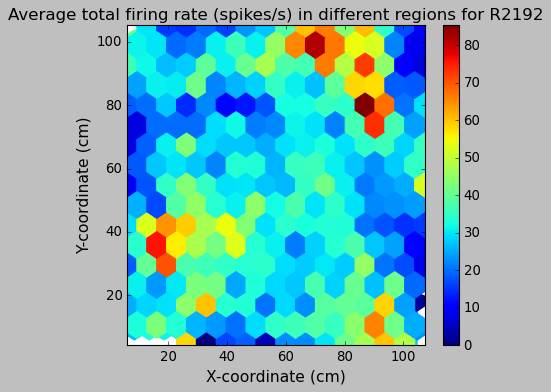

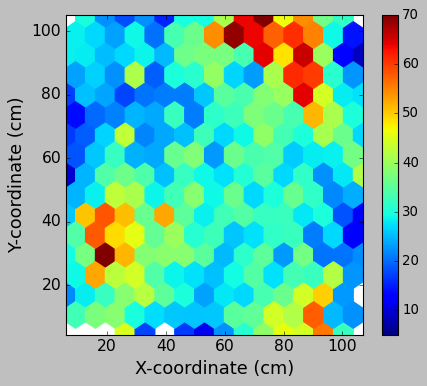

In [10]:
import scipy.io as scio
spike_data=scio.loadmat("data/R2192_20ms")['mm']
all_info = scio.loadmat("data/R2192_data.mat")
locations = all_info["data"][0][0][4][0][0][3]/3.5
sum_activity = np.sum(spike_data,axis=0)*50
print(np.shape(spike_data), np.shape(locations), np.shape(sum_activity))

plt.clf()
plt.figure(figsize=(6,5))
plt.title("Average total firing rate (spikes/s) in different regions for R2192",fontsize=15)
all_raw_collection20 = plt.hexbin(locations[:,0], locations[:,1],C=sum_activity, gridsize = 20)
all_raw_hexes20 = all_raw_collection20.get_array()
all_raw_collection15 = plt.hexbin(locations[:,0], locations[:,1],C=sum_activity, gridsize = 15)
all_raw_hexes15 = all_raw_collection15.get_array()
plt.xlim([np.min(locations[:,0]), np.max(locations[:,0])])
plt.ylim([np.min(locations[:,1]), np.max(locations[:,1])])
plt.xlabel("X-coordinate (cm)",fontsize=14)
plt.ylabel("Y-coordinate (cm)",fontsize=14)
plt.colorbar();
plt.savefig("../mean_activity2D_20ms.png")
plt.savefig("../mean_activity2D_20ms.eps", format='eps')
#print all_raw_hexes15

# This is based on only train set and on 1400ms windows
plt.figure(figsize=(6,5))
#plt.title("Sum neural activity in spikes/s in different regions for R2192",fontsize=15)
plt.hexbin(y[:,0], y[:,1],C=activity/1.4, gridsize=15, vmin=5, vmax=70)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.xlabel("X-coordinate (cm)",fontsize=16)
plt.ylabel("Y-coordinate (cm)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar(ticks=[0,10,20,30,40,50,60,70]);
cbar.ax.set_yticklabels([10,20,30,40,50,60,70],fontsize=14)
plt.tight_layout()
plt.savefig("../mean_activity2D_1400ms.png")
plt.savefig("../mean_activity2D_1400ms.eps", format='eps')

## DISTRIBUTIONS OF ERRORS -- FIGURE 2a

In [11]:
import scipy.io as scio

### READ IN ERRORS MADE BY BAYES WITH MEMORY
# bayes_mem_preds = scio.loadmat("Bayes_results/BayesMemory_R2192_2200ms.mat") #-- with wrong history size
bayes_mem_preds = scio.loadmat("Bayes_results/Fig2a_2d2-2TimeWindowFullErrorWithBayesMem.mat")
print(bayes_mem_preds.keys())
print(len(bayes_mem_preds["animalStruct"][0][0][1][0][0][1]))
b_mem_errors = bayes_mem_preds["animalStruct"][0][0][1][0][0][3]
print(np.mean(b_mem_errors))
print(np.median(b_mem_errors))

dict_keys(['__header__', '__version__', '__globals__', 'bstMean', 'bstMedian', 'tWin2Test', 'meanErr', 'medianErr', 'animalStruct'])
970
15.486145077067173
12.16552506059644


In [12]:
# READ IN TRUE AND PERDICTED LOC WITH BAYES FLAT
x = scio.loadmat("Bayes_results/Fig2a_2dDecode2cmBins.mat")
print(x.keys())
print("13th corresponds to 2800ms", x["animalStruct"][0][0][1][0][13][0])
true_loc = x["animalStruct"][0][0][1][0][13][1]
pred_loc = x["animalStruct"][0][0][1][0][13][2]
errors= np.sqrt(np.sum((true_loc-pred_loc)**2,axis=1))

print(np.mean(errors), np.mean(avg_errors))
print(np.median(errors), np.median(avg_errors))

dict_keys(['__header__', '__version__', '__globals__', 'bstMean', 'bstMedian', 'animalStruct'])
13th corresponds to 2800ms [[2.8]]
15.829630734566596 12.529120902434991
12.165525060596439 10.501569161031325


15.829630734566596 12.529120902434991
12.165525060596439 10.501569161031325


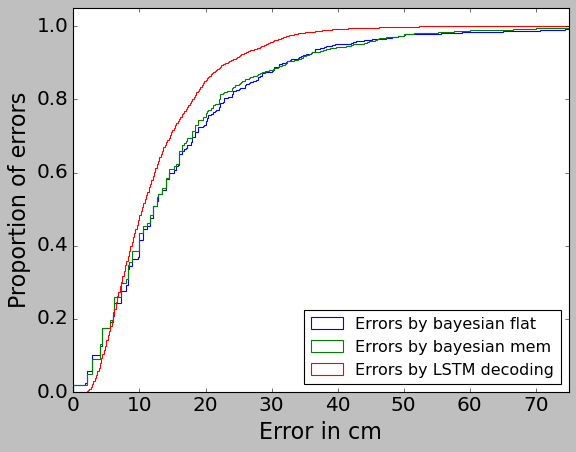

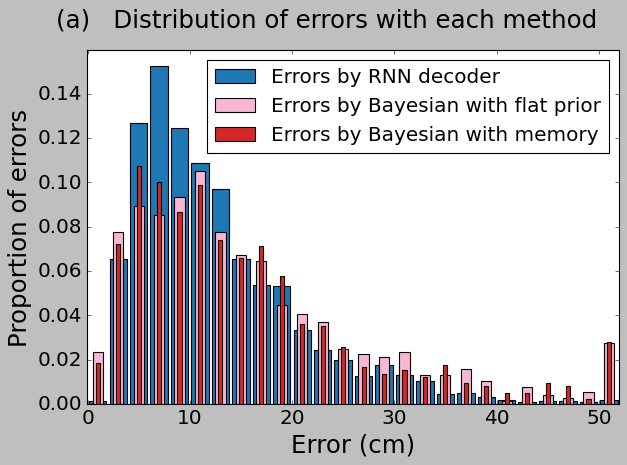

4414 76
4414 7
proportion: 0.07894736842105263 0.08144329896907217
proportion: 0.02763157894736842 0.026804123711340205


In [13]:
# The true and predicted vals are also saved in .txt file
#predR2192 = np.loadtxt("Bayes_results/R2192_2800ms_flatBayes_predicted_loc.txt")
#trueR2192 = np.loadtxt("Bayes_results/R2192_2800ms_flatBayes_true_loc.txt")
#errors= np.sqrt(np.sum((predR2192-trueR2192)**2,axis=1))
errors_clipped= np.clip(errors,0,50)

print(np.mean(errors), np.mean(avg_errors))
print(np.median(errors), np.median(avg_errors))

plt.hist(errors,bins=np.arange(0,80,0.2),histtype="step",align="mid",rwidth=0.5, weights=np.ones_like(errors)/len(errors),label="Errors by bayesian flat",cumulative=True)
plt.hist(b_mem_errors,bins=np.arange(0,80,0.2),histtype="step",align="mid",rwidth=0.5, weights=np.ones_like(b_mem_errors)/len(b_mem_errors),label="Errors by bayesian mem",cumulative=True)
plt.hist(avg_errors, bins=np.arange(0,80,0.2),histtype="step",align="mid",rwidth=0.25, weights=np.ones_like(avg_errors)/(len(avg_errors)),label="Errors by LSTM decoding",cumulative=True)
plt.legend(loc=4)
plt.xlabel("Error in cm",fontsize=20)
plt.ylabel("Proportion of errors",fontsize=20)
plt.xlim(-0.1,75)
plt.ylim(0,1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()




plt.figure(figsize=(8,6))
plt.clf()
#RNN
plt.hist(np.clip(avg_errors,0,52), bins=np.arange(0,52.1,2), color=tableau20[0],align="mid",rwidth=0.85, weights=np.ones_like(avg_errors)/(len(avg_errors)),label="Errors by RNN decoder")
# flat bayes
plt.hist(np.clip(errors,0,52),bins=np.arange(0,52.1,2),color=tableau20[13], align="mid",rwidth=0.5, weights=np.ones_like(errors)/len(errors),label="Errors by Bayesian with flat prior")
# bayes with mem
plt.hist(np.clip(b_mem_errors,0,52),bins=np.arange(0,52.1,2),color=tableau20[6], align="mid",rwidth=0.2, weights=np.ones_like(b_mem_errors)/len(b_mem_errors),label="Errors by Bayesian with memory")

plt.legend(loc=1,fontsize=18)
plt.title("(a)   Distribution of errors with each method", fontsize=22,y=1.05,x=0.45)
plt.xlabel("Error (cm)",fontsize=22)
plt.ylabel("Proportion of errors", fontsize=22)
plt.xlim(-0.1,52)
plt.ylim(0,0.16)
plt.xticks(fontsize=18)
plt.yticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14],fontsize=18)
plt.tight_layout()
plt.savefig("f3a.png")
plt.show()

print(len(avg_errors), np.sum(avg_errors > 35))
print(len(avg_errors), np.sum(avg_errors > 50))

print("proportion:", np.sum(errors > 35) / (1.0 * len(errors)), np.sum(b_mem_errors > 35) / (1.0 * len(b_mem_errors)))
print("proportion:", np.sum(errors > 50) / (1.0 * len(errors)), np.sum(b_mem_errors > 50) / (1.0 * len(b_mem_errors)))

In [14]:
from scipy.stats import pearsonr,spearmanr

print("CORRELATION BETWEEN ERROR; ACTIVITY; NR NEIGHBOURS")

print("\n peasron for LOG activity vs error", pearsonr(np.log(activity), np.log(avg_errors)))
print("\n spearman activity vs error", spearmanr(activity, avg_errors))
print("\n spearman nr neighbours vs error", spearmanr(count_nearby, avg_errors))

print("\n spearman (nr_neigh vs activity)", spearmanr(count_nearby, activity), "--> not SIGNIFICANT")


CORRELATION BETWEEN ERROR; ACTIVITY; NR NEIGHBOURS

 peasron for LOG activity vs error (-0.3203749802872534, 6.569038627413649e-106)

 spearman activity vs error SpearmanrResult(correlation=-0.31485083482862447, pvalue=3.665519501365258e-102)

 spearman nr neighbours vs error SpearmanrResult(correlation=-0.16043880723926895, pvalue=7.705630988381291e-27)

 spearman (nr_neigh vs activity) SpearmanrResult(correlation=0.011982594170028815, pvalue=0.42608901104986374) --> not SIGNIFICANT


Text(0.5, 1.0, 'Errors over arena (cm)')

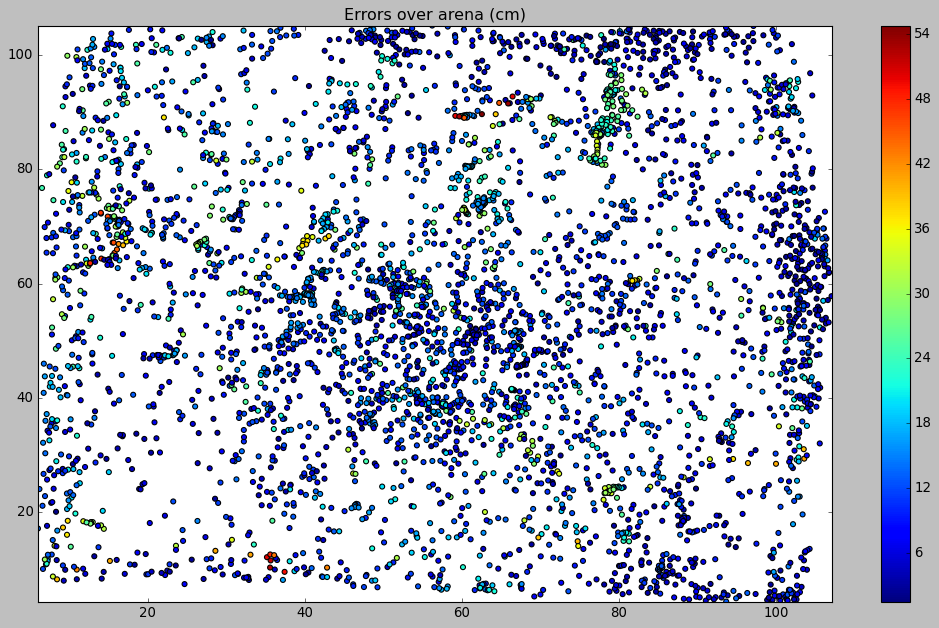

In [15]:
plt.figure(figsize=(16,9))
plt.scatter(y[:,0], y[:,1],c=avg_errors)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.colorbar();
plt.title("Errors over arena (cm)")

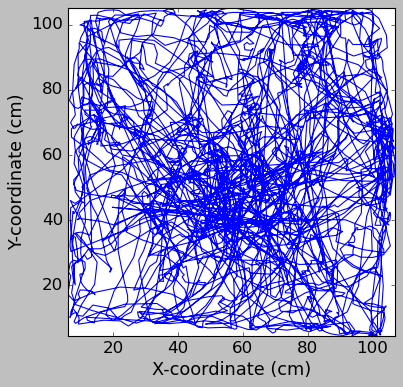

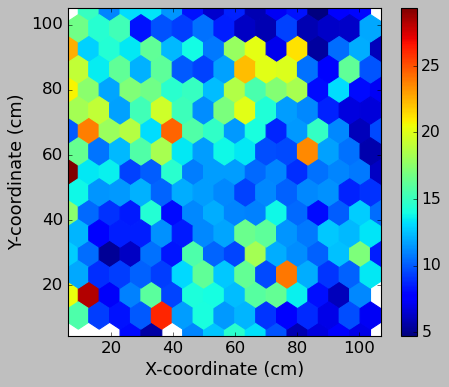

In [16]:
plt.figure(figsize=(5.2,5))
plt.plot(y[:,0], y[:,1], )
plt.xlabel("X-coordinate (cm)",fontsize=16)
plt.ylabel("Y-coordinate (cm)",fontsize=16)
#plt.title("Trajectory of R2192")
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("../trajectory.png")
plt.savefig("../trajectory.eps",format='eps')

plt.figure(figsize=(6,5))
#plt.title("Mean prediction error in different regions for R2192")
plt.hexbin(y[:,0], y[:,1],C=avg_errors, gridsize=15)
plt.xlabel("X-coordinate (cm)",fontsize=16)
plt.ylabel("Y-coordinate (cm)",fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar( ticks=[5,10,15,20,25])
cbar.ax.set_yticklabels([5,10,15,20,25],fontsize=14)
#cbar.ax.set_yticklabels(["5 cm","10 cm","15 cm","20 cm","25 cm"],fontsize=14)
#cbar.ax.set_title('Mean error',fontsize=14)
plt.tight_layout()
plt.savefig("../mean2D_10models.png")
plt.savefig("../mean2D_10models.eps",format='eps')

In [17]:
xerrors = np.abs(avg_pred[:,0] - y[:,0])
yerrors = np.abs(avg_pred[:,1] - y[:,1])
print(np.mean(xerrors), np.mean(yerrors))

7.466272300979984 7.280410555365286


Text(0.5, 1.0, 'Y prediction error')

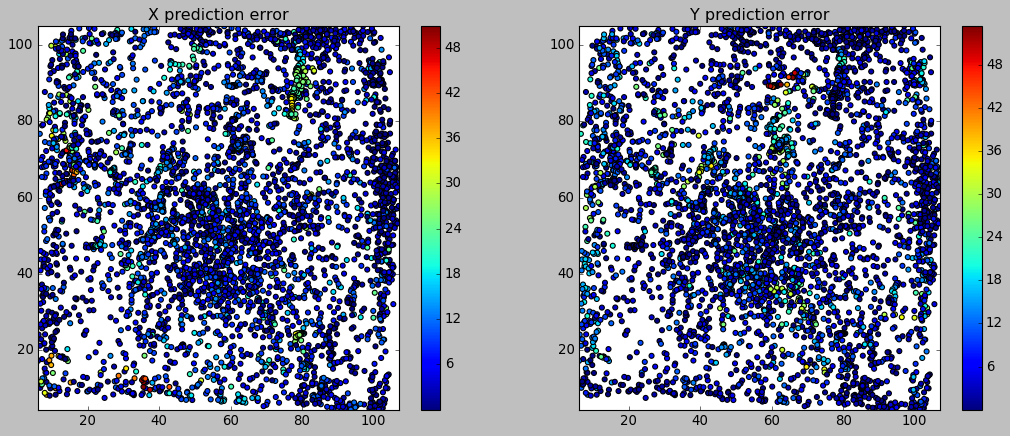

In [18]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(y[:,0], y[:,1],c=xerrors)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.colorbar();
plt.title("X prediction error")
plt.subplot(1,2,2)
plt.scatter(y[:,0], y[:,1],c=yerrors)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.colorbar();
plt.title("Y prediction error")

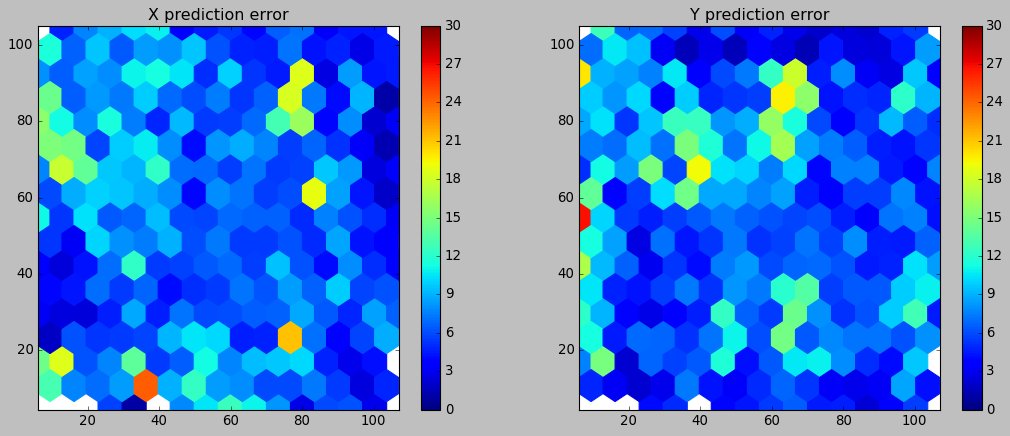

In [19]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("X prediction error")
plt.hexbin(y[:,0], y[:,1],C=xerrors, gridsize=15, vmin=0, vmax=30)
plt.colorbar();
plt.subplot(1,2,2)
plt.title("Y prediction error")
plt.hexbin(y[:,0], y[:,1],C=yerrors, gridsize=15, vmin=0, vmax=30)
plt.colorbar();

## Error with respect to the direction perpendicular to the wall

(8828,) (8828,)


<Figure size 1280x480 with 0 Axes>

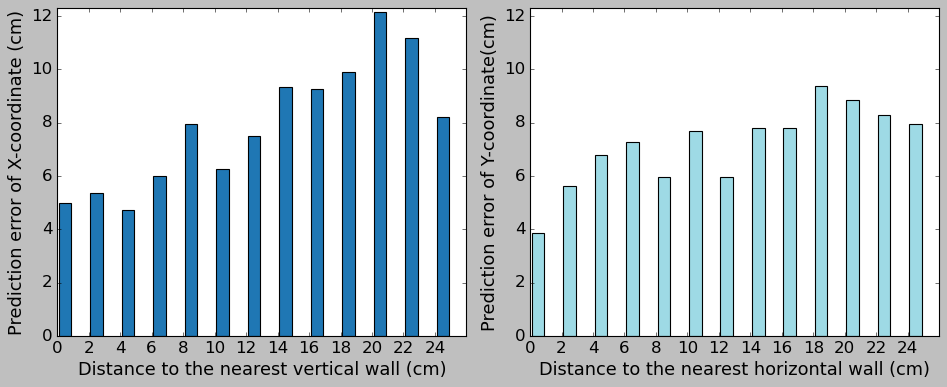

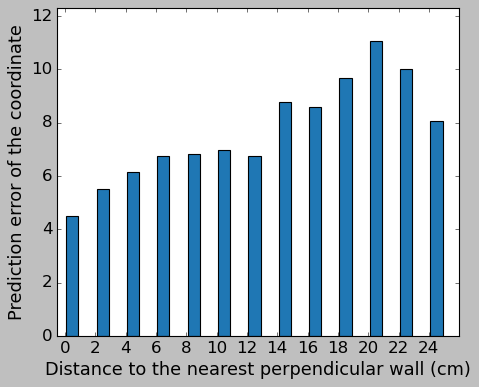

In [20]:
plt.figure(figsize=(16,6))
bins = np.arange(0,100.1, 2)


### the same but mirrored from the center - so we conider distnace from closest wall
bins = np.arange(0,50.1, 2)

plt.figure(figsize=(12,5))
nb_bins = 20

statisticX, bin_edgesX, binnumberX = binned_statistic(50-np.abs(y[:,0]-50), xerrors, statistic='mean', bins=bins)
plt.subplot(1,2,1)
plt.bar(bin_edgesX[1:]-1.5, statisticX, color=tableau20[0])
#plt.title("$Error_x = f(D_{vertical\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of X-coordinate (cm)",fontsize=16)
plt.xlabel("Distance to the nearest vertical wall (cm)",fontsize=16)
plt.ylim([0,12.3])
plt.xlim([0.5,26])
plt.xticks(np.arange(0,24.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)


statisticY, bin_edgesY, binnumberY = binned_statistic(50-np.abs(y[:,1]-50), yerrors, statistic='mean', bins=bins)
plt.subplot(1,2,2)
plt.bar(bin_edgesY[1:]-1.5, statisticY, color=tableau20[19])
#plt.title("$Error_y = f(D_{horizontal\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of Y-coordinate(cm)",fontsize=16)
plt.xlabel("Distance to the nearest horizontal wall (cm)",fontsize=16)
plt.ylim([0,12.3])
plt.xlim([0.5,26])
plt.xticks(np.arange(0,24.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)
plt.tight_layout()
plt.savefig("error_walls.png")

######################
plt.figure(figsize=(6,5))

all_1D_err = np.concatenate((xerrors,yerrors))
all_distances_to_wall = np.concatenate((50-np.abs(y[:,0]-50),50-np.abs(y[:,1]-50)))
print(all_1D_err.shape, all_distances_to_wall.shape)
statistic, bin_edges, binnumber = binned_statistic(all_distances_to_wall, all_1D_err, statistic='mean', bins=bins)
plt.bar(bin_edges[1:]-1.5, statistic, color=tableau20[0])
#plt.title("$Error_y = f(D_{horizontal\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of the coordinate",fontsize=16)
plt.xlabel("Distance to the nearest perpendicular wall (cm)",fontsize=16)
plt.ylim([0,12.3])
plt.xlim([-0.5,26])
plt.xticks(np.arange(0,24.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)
plt.tight_layout()
plt.savefig("error_walls_combined.png")

## error with respect to the direction parallel to the wall -- NO CORRELATION

<Figure size 1280x480 with 0 Axes>

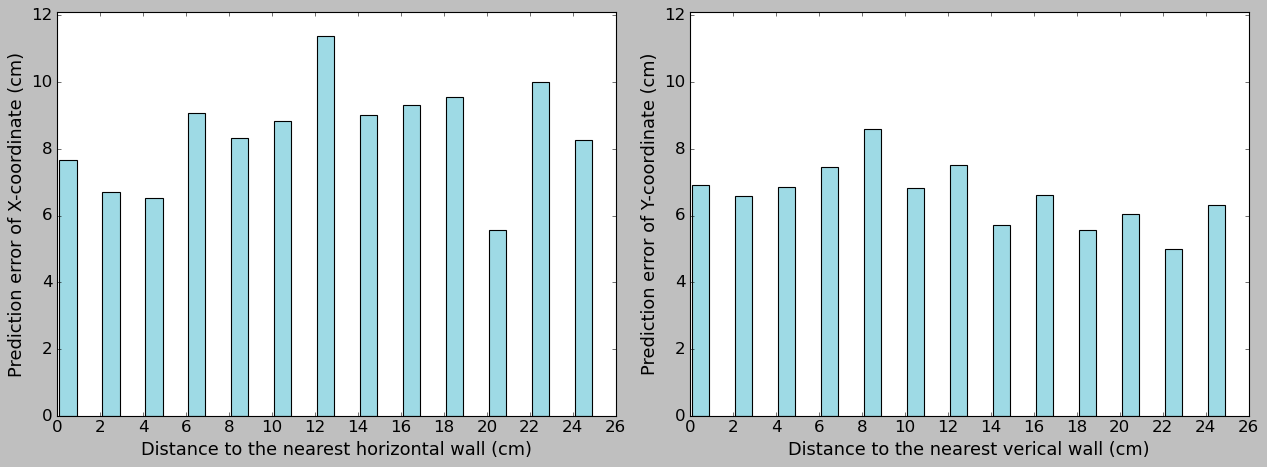

In [21]:
# error with respect to the direction parallel to the wall -- NO CORRELATION
plt.figure(figsize=(16,6))
bins = np.arange(0,100.1, 2)


################# mirrored at the center
bins = np.arange(0,50.1, 2)
plt.figure(figsize=(16,6))
nb_bins = 20
statistic, bin_edges, binnumber = binned_statistic(50-np.abs(y[:,1]-50), xerrors, statistic='mean', bins=bins)
plt.subplot(1,2,1)
plt.bar(bin_edges[1:]-1.5, statistic, color=tableau20[19])
#plt.title("$Error_x = f(D_{horizontal\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of X-coordinate (cm)",fontsize=16)
plt.xlabel("Distance to the nearest horizontal wall (cm)",fontsize=16)
plt.ylim([0,13])
plt.xlim([0.5,26])
plt.xticks(np.arange(0,26.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)
plt.ylim([0,12.1])



statistic, bin_edges, binnumber = binned_statistic(50-np.abs(y[:,0]-50), yerrors, statistic='mean', bins=bins)
plt.subplot(1,2,2)
plt.bar(bin_edges[1:]-1.5, statistic, color=tableau20[19])
#plt.title("$Error_y = f(D_{vertical\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of Y-coordinate (cm)",fontsize=16)
plt.xlabel("Distance to the nearest verical wall (cm)",fontsize=16)
plt.ylim([0,13])
plt.xlim([0.5,26])
plt.xticks(np.arange(0,26.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)
plt.ylim([0,12.1])
plt.tight_layout()
plt.savefig("error_walls_parallel.png")

## STATISTICAL SIGNIFICANCE OF WALL-ERROR RELATIONSHIP

In [22]:
from scipy.stats import pearsonr,spearmanr
# HOW ABOUT STATISTICAL SIGNIFICANCE ?

all_1D_err = np.concatenate((xerrors,yerrors))
all_distances_to_wall = np.concatenate((50-np.abs(y[:,0]-50),50-np.abs(y[:,1]-50)))

#we are only interested in the zone near the walls
zone_near_wall_idx = np.where(all_distances_to_wall<25.001)

#extract data from region of interest (ROI)
roi_errs = all_1D_err[zone_near_wall_idx]
roi_wall_dists = all_distances_to_wall[zone_near_wall_idx]
#plt.plot( roi_wall_dists,roi_errs, "o")
print(" Errors combined: spearman .......", spearmanr(roi_errs, roi_wall_dists), len(roi_errs))

## for X coord alone
all_errs = xerrors
all_distances_to_wall = 50-np.abs(y[:,0]-50)

zone_near_wall_idx = np.where(all_distances_to_wall<25.001)
roi_errs = all_errs[zone_near_wall_idx]
roi_wall_dists = all_distances_to_wall[zone_near_wall_idx]
print(" X-coord Errors : spearman .......", spearmanr(roi_errs, roi_wall_dists), len(roi_errs))

## for Y coord alone
all_errs = yerrors
all_distances_to_wall = 50-np.abs(y[:,1]-50)
zone_near_wall_idx = np.where(all_distances_to_wall<25.001)
roi_errs = all_errs[zone_near_wall_idx]
roi_wall_dists = all_distances_to_wall[zone_near_wall_idx]
print("  Y-coord Errors : spearman .......", spearmanr(roi_errs, roi_wall_dists), len(roi_errs))


 Errors combined: spearman ....... SpearmanrResult(correlation=0.30841427082876083, pvalue=5.09538127632798e-88) 3960
 X-coord Errors : spearman ....... SpearmanrResult(correlation=0.353731659027682, pvalue=5.061538218736698e-63) 2103
  Y-coord Errors : spearman ....... SpearmanrResult(correlation=0.2492969894720718, pvalue=1.0511846509469062e-27) 1857


## SPEED AND ERROR

In [23]:
diff = y[1:,:] - y[:-1,:]
print(diff.shape)
dists = np.sqrt(np.sum(diff**2, axis=1))
print(dists.shape, np.mean(dists))

(4413, 2)
(4413,) 3.7924232811984324


edges [ 441  883 1325 1767 2208 2649 3090 3531 3972]
[44.85415513 58.60256619 62.25931673 72.85410459 83.4080241  80.84225341
 58.59452233 46.34623049 56.57595575]
remianing largest speed is 14.64221976409315
count [483. 908. 670. 445. 426. 336. 263. 276. 197. 160. 100.  75.  35.  24.] len 14 15
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5] 14 [16.45198588 13.81603617 12.10556906 11.93469928 11.63889985 11.21829538
 10.69601339 10.62558836 11.27291365 10.88712665 11.9685629  12.03223589
 11.05775632 12.9643255 ]
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5] 14 [15.73170179 11.99434384 10.04919404  9.59301674  9.42169044  9.55983762
  9.39607895  9.51604642  9.32998247  9.44069229  9.25161191 11.00430458
  9.79470645 11.15339673]
#############################################
STDs are way too huge [8.67770731 8.72249773 7.6965568  8.26884757 7.87749834 7.25865119
 6.1768065  5.6909009  6.66147217 6.70495972 7.95077139 6.4584

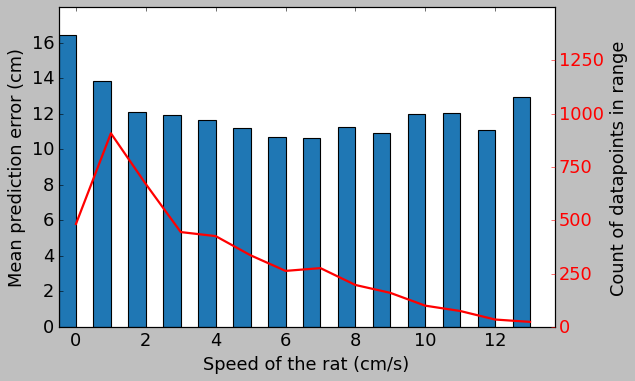

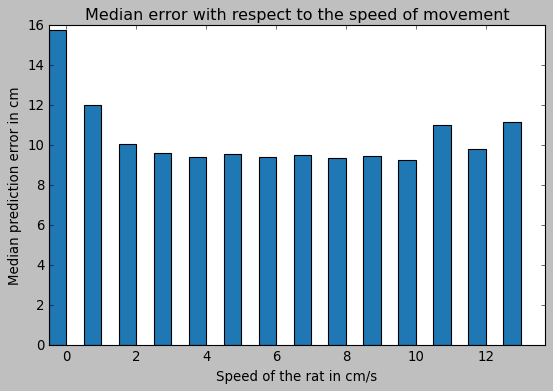

In [24]:

# disconitnuous points between folds - speed would show up as huge, sow e need to delete them
edges=np.cumsum([441,442,442,442,441,441,441,441,441])
print("edges", edges)
print(dists[edges])

dists_wo_edges = np.delete(dists, edges)
errors_wo_edges = np.delete(avg_errors[1:],edges)
#errors_wo_edges = np.delete(median_errors[1:],edges)
print("remianing largest speed is", np.max(dists_wo_edges))

count_in_bin, bin_edges, binnumber = binned_statistic(dists_wo_edges, errors_wo_edges, statistic='count',
                                                   bins=np.arange(-0.5,13.6,1))
print("count", count_in_bin, "len", len(count_in_bin), len(np.arange(-0.5, 13.6, 1)))

statistic, bin_edges, binnumber = binned_statistic(dists_wo_edges, errors_wo_edges, statistic='mean',
                                                   bins=np.arange(-0.5,13.6,1))
print(bin_edges, len(statistic), statistic)

fig, ax1 = plt.subplots(figsize=(8,5))#8,5 seems thebesty, 7,4 is ok
ax2 = ax1.twinx()

ax1.bar(bin_edges[:-1]+0.25, statistic, width=0.5, color=tableau20[0]);
ax1.set_xlim([-0.5,13.7])
#ax1.set_title("Mean error with respect to the speed of movement", fontsize=15)
ax1.set_xlabel("Speed of the rat (cm/s)", fontsize=16)
ax1.set_ylabel("Mean prediction error (cm)", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_yticks([0,2,4,6,8,10,12,14,16])


ax2.plot(range(14),count_in_bin,color="r", linewidth=2)
ax2.set_ylabel("Count of datapoints in range", fontsize=16)
ax2.set_ylim([0,1500])
ax2.tick_params(colors='r',labelsize=16)
ax2.set_yticks([0,250,500,750,1000,1250])


fig.savefig("speed_with_count.png")


#print avg_errors[:10], median_errors[:10], np.mean(avg_errors),np.mean(median_errors)
errors_wo_edges = np.delete(avg_errors[1:],edges)

statistic, bin_edges, binnumber = binned_statistic(dists_wo_edges, errors_wo_edges, statistic='median',
                                                   bins=np.arange(-0.5,13.6,1))
print(bin_edges, len(statistic), statistic)
plt.figure(figsize=(8,5))
plt.bar(bin_edges[:-1]+0.25, statistic, width=0.5, color=tableau20[0]);
plt.xlim([-0.5,13.7])
plt.title("Median error with respect to the speed of movement")
plt.xlabel("Speed of the rat in cm/s")
plt.ylabel("Median prediction error in cm")

print("#############################################")
statistic, bin_edges, binnumber = binned_statistic(dists_wo_edges, errors_wo_edges, statistic=np.std,
                                                   bins=np.arange(-0.5,13.6,1))
print("STDs are way too huge", statistic)

print("speed in first bin", dists_wo_edges[np.where(binnumber == 1)[0]][:5])
print(np.mean(errors_wo_edges[np.where(binnumber == 1)[0]]))
print(np.std(errors_wo_edges[np.where(binnumber == 1)[0]]))

print("\n speeds above 0.5 cm/s:")
print(np.mean(errors_wo_edges[np.where(binnumber > 1)[0]]))
print(np.std(errors_wo_edges[np.where(binnumber > 1)[0]]))

print("\n speeds above 1.5 cm/s:")
print(np.mean(errors_wo_edges[np.where(binnumber > 2)[0]]))
print(np.std(errors_wo_edges[np.where(binnumber > 2)[0]]))

print("\n speeds above 9.5 cm/s:")
print(np.mean(errors_wo_edges[np.where(binnumber > 11)[0]]))
print(np.std(errors_wo_edges[np.where(binnumber > 11)[0]]))

print("\n speeds above 12.5 cm/s:")
print(np.mean(errors_wo_edges[np.where(binnumber > 13)[0]]))
#print np.mean(errors_wo_edges[np.where(dists_wo_edges>12.5)[0]])  #just a sanity check!
print(np.std(errors_wo_edges[np.where(binnumber > 13)[0]]))

In [25]:
# STATS FOR SPEED RESULTS

from scipy import stats

# we want two-sided and no restriction on variance (beacuse not equal var)

standing_still = errors_wo_edges[np.where(dists_wo_edges < 0.5)[0]]
in_motion = errors_wo_edges[np.where(dists_wo_edges > 0.5)[0]]
normal_motion = errors_wo_edges[np.where(np.logical_and(dists_wo_edges > 0.5, dists_wo_edges <10.5))[0]]
fast_speed = errors_wo_edges[np.where(dists_wo_edges > 10.5)[0]]

print(stats.ttest_ind(standing_still, in_motion, equal_var=False))

print(stats.ttest_ind(normal_motion, fast_speed, equal_var=False))


Ttest_indResult(statistic=10.619823773035726, pvalue=3.3967303748942815e-24)
Ttest_indResult(statistic=0.3125900175454586, pvalue=0.7550141549760705)


## ----------------------------------------------------------------
## Downsampling results

In [26]:
import scipy.io as scio
bayes_flat_downsample = scio.loadmat("Bayes_results/Fig2bc_downSampResultsCompl.mat")
print(bayes_flat_downsample.keys())
bayes_flat_downsample_means = bayes_flat_downsample["allMeanErr"]

bayes_flat_downsample_medians = bayes_flat_downsample["allMedianErr"]
#print bayes_flat_downsample["dwnSamp"]

#bayes_mem_downsample = scio.loadmat("Bayesian_results/downSampResultsWithBayesHistory.mat")
bayes_mem_downsample = scio.loadmat("Bayes_results/Fig2bc_downSampResultsWithBayesHistoryTWin1-2.mat")

print(bayes_mem_downsample.keys())
bayes_mem_downsample_means = bayes_mem_downsample["allMeanErr"]
bayes_mem_downsample_medians = bayes_mem_downsample["allMedianErr"]


dict_keys(['__header__', '__version__', '__globals__', 'allMeanErr', 'allMedianErr', 'dwnSamp'])
dict_keys(['__header__', '__version__', '__globals__', 'allMeanErr', 'allMedianErr'])


In [27]:
f=np.loadtxt("R2192_models/downsampling_results/means_and_medians.txt",dtype=str)
mea_and_med = f[:,[-5,-1]]
mea_and_med[:,0] = map(lambda x: float(x[:-1]),mea_and_med[:,0] )
mea_and_med[:,1] = map(lambda x: float(x[:-1]),mea_and_med[:,1] )

mea_and_med= np.array(mea_and_med,dtype=float)

sample_sizes=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
              10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
              15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
              20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
              25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
              30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
              35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
              40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
              45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
              50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
              55, 55, 55, 55, 55, 55, 55, 55, 55, 55]

###############################################

plt.figure(figsize=(8,6))
plt.plot(sample_sizes,mea_and_med[:,0],'o',color=tableau20[1])
plt.xlim([4,57])
#print np.reshape(mea_and_med[:,1],(5,10))

bay_flat_means = bayes_flat_downsample_means
print(bay_flat_means.shape, np.mean(bay_flat_means, axis=1))
plt.plot([5,10,15,20,25,30,35,40,45,50,55],np.mean(bay_flat_means,axis=1),color=tableau20[13], linewidth=3,label="Bayesian with flat prior (MLE)")
plt.plot(sample_sizes,bay_flat_means.flatten(),'o',color=tableau20[13])
plt.yticks([0,5,10,15,20,25,30,35,40,45],fontsize=20)
plt.xticks([5,10,15,20,25,30,35,40,45,50,55],fontsize=20)
plt.ylim([9,50])

bay_mem_means = bayes_mem_downsample_means
print(bay_mem_means.shape, np.mean(bay_mem_means, axis=1))
plt.plot([5,10,15,20,25,30,35,40,45,50,55],np.mean(bay_mem_means,axis=1),color="red", linewidth=3,label="Bayesian with memory")
plt.plot(sample_sizes,bay_mem_means.flatten(),'o',color="red")
plt.yticks([0,5,10,15,20,25,30,35,40,45],fontsize=20)
plt.xticks([5,10,15,20,25,30,35,40,45,50,55],fontsize=20)
plt.ylim([9,50])


mean_of_means = np.mean(np.reshape(mea_and_med[:,0],(11,10)),axis=1)
plt.plot([5,10,15,20,25,30,35,40,45,50,55],mean_of_means,color=tableau20[0], linewidth=3,label="RNN model")
plt.ylabel("Mean error (cm)",fontsize=20)
plt.xlabel("Number of sampled neurons",fontsize=20)
print(mean_of_means, np.std(np.reshape(mea_and_med[:, 0], (11, 10)), axis=1))
plt.legend(fontsize=19)
plt.title("(b)  Mean results with downsampled datasets",fontsize=22, y=1.05,x=0.45)
plt.tight_layout()

plt.savefig("mean_down.png")
plt.show()

##########################################################

plt.figure(figsize=(8,6))
plt.clf()
plt.plot(sample_sizes,mea_and_med[:,1],'o',color=tableau20[1])
plt.xlim([4,57])
#print np.reshape(mea_and_med[:,1],(5,10))


bay_flat_medians = bayes_flat_downsample_medians
plt.plot([5,10,15,20,25,30,35,40,45,50,55],np.mean(bay_flat_medians,axis=1),color=tableau20[13], linewidth=3,label="Bayesian with flat prior (MLE)")
plt.plot(sample_sizes,bay_flat_medians.flatten(),'o',color=tableau20[13])
plt.ylim([9,50])
plt.yticks([0,5,10,15,20,25,30,35,40,45],fontsize=20)
plt.xticks([5,10,15,20,25,30,35,40,45,50,55],fontsize=20)
#print mean_of_medians, np.std(np.reshape(mea_and_med[:,1],(11,10)),axis=1)
print(np.mean(bay_flat_medians, axis=1))

bay_mem_medians = bayes_mem_downsample_medians
plt.plot([5,10,15,20,25,30,35,40,45,50,55],np.mean(bay_mem_medians,axis=1),color="red", linewidth=3,label="Bayesian with memory")
plt.plot(sample_sizes,bay_mem_medians.flatten(),'o',color="red")
plt.ylim([9,50])
plt.yticks([0,5,10,15,20,25,30,35,40,45],fontsize=20)
plt.xticks([5,10,15,20,25,30,35,40,45,50,55],fontsize=20)
#print mean_of_medians, np.std(np.reshape(mea_and_med[:,1],(11,10)),axis=1)
print(np.mean(bay_mem_medians, axis=1))

mean_of_medians = np.mean(np.reshape(mea_and_med[:,1],(11,10)),axis=1)
plt.plot([5,10,15,20,25,30,35,40,45,50,55],mean_of_medians,color=tableau20[0],label="RNN model",linewidth=3)
plt.ylim([9,50])
plt.ylabel("Median error (cm)",fontsize=20)
plt.xlabel("Number of sampled neurons",fontsize=20)


plt.legend(fontsize=19)
plt.title("(c)  Median results with downsampled datasets",fontsize=22, y=1.05,x=0.45)
plt.tight_layout()
plt.savefig("median_down.png")
plt.show()



ValueError: could not convert string to float: '<map object at 0x7fbaf01880d0>'